In [220]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import matplotlib.pyplot as plt
# from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error as mse
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from sklearn import ensemble

In [15]:
# Import data
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)

print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [16]:
#get info

def get_details(data):
    skew= data.skew()
    corr = data.corr()['SalePrice']

    nulls = data.apply(lambda x: x.isnull().sum())
    nulls_perc = data.apply(lambda x: x.isnull().sum()/data.shape[0]*100)
    unique = data.apply(lambda x: [x.unique()])

    details = pd.concat([skew, corr, nulls, nulls_perc, unique], axis=1, sort=False)
    details.columns = ['skew', 'corr', 'nulls', 'nulls_perc', 'unique']
    
    return details

In [17]:
cat = train.select_dtypes(include=['O']).columns
cont = train.select_dtypes(exclude=['O']).columns

In [18]:
details = get_details(train[cont]).sort_values('corr', ascending = False).iloc[1:].head(12)
details

,skew,corr,nulls,nulls_perc,unique
OverallQual,0.216944,0.790982,0,0.000000,"[[7.0, 6.0, 8.0, 5.0, 9.0, 4.0, 10.0, 3.0, 1.0..."
GrLivArea,1.366560,0.708624,0,0.000000,"[[1710.0, 1262.0, 1786.0, 1717.0, 2198.0, 1362..."
GarageCars,-0.342549,0.640409,0,0.000000,"[[2.0, 3.0, 1.0, 0.0, 4.0]]"
GarageArea,0.179981,0.623431,0,0.000000,"[[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 63..."
TotalBsmtSF,1.524255,0.613581,0,0.000000,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
1stFlrSF,1.376757,0.605852,0,0.000000,"[[856.0, 1262.0, 920.0, 961.0, 1145.0, 796.0, ..."
FullBath,0.036562,0.560664,0,0.000000,"[[2.0, 1.0, 3.0, 0.0]]"
TotRmsAbvGrd,0.676341,0.533723,0,0.000000,"[[8.0, 6.0, 7.0, 9.0, 5.0, 11.0, 4.0, 10.0, 12..."
YearBuilt,-0.613461,0.522897,0,0.000000,"[[2003.0, 1976.0, 2001.0, 1915.0, 2000.0, 1993..."
YearRemodAdd,-0.503562,0.507101,0,0.000000,"[[2003.0, 1976.0, 2002.0, 1970.0, 2000.0, 1995..."


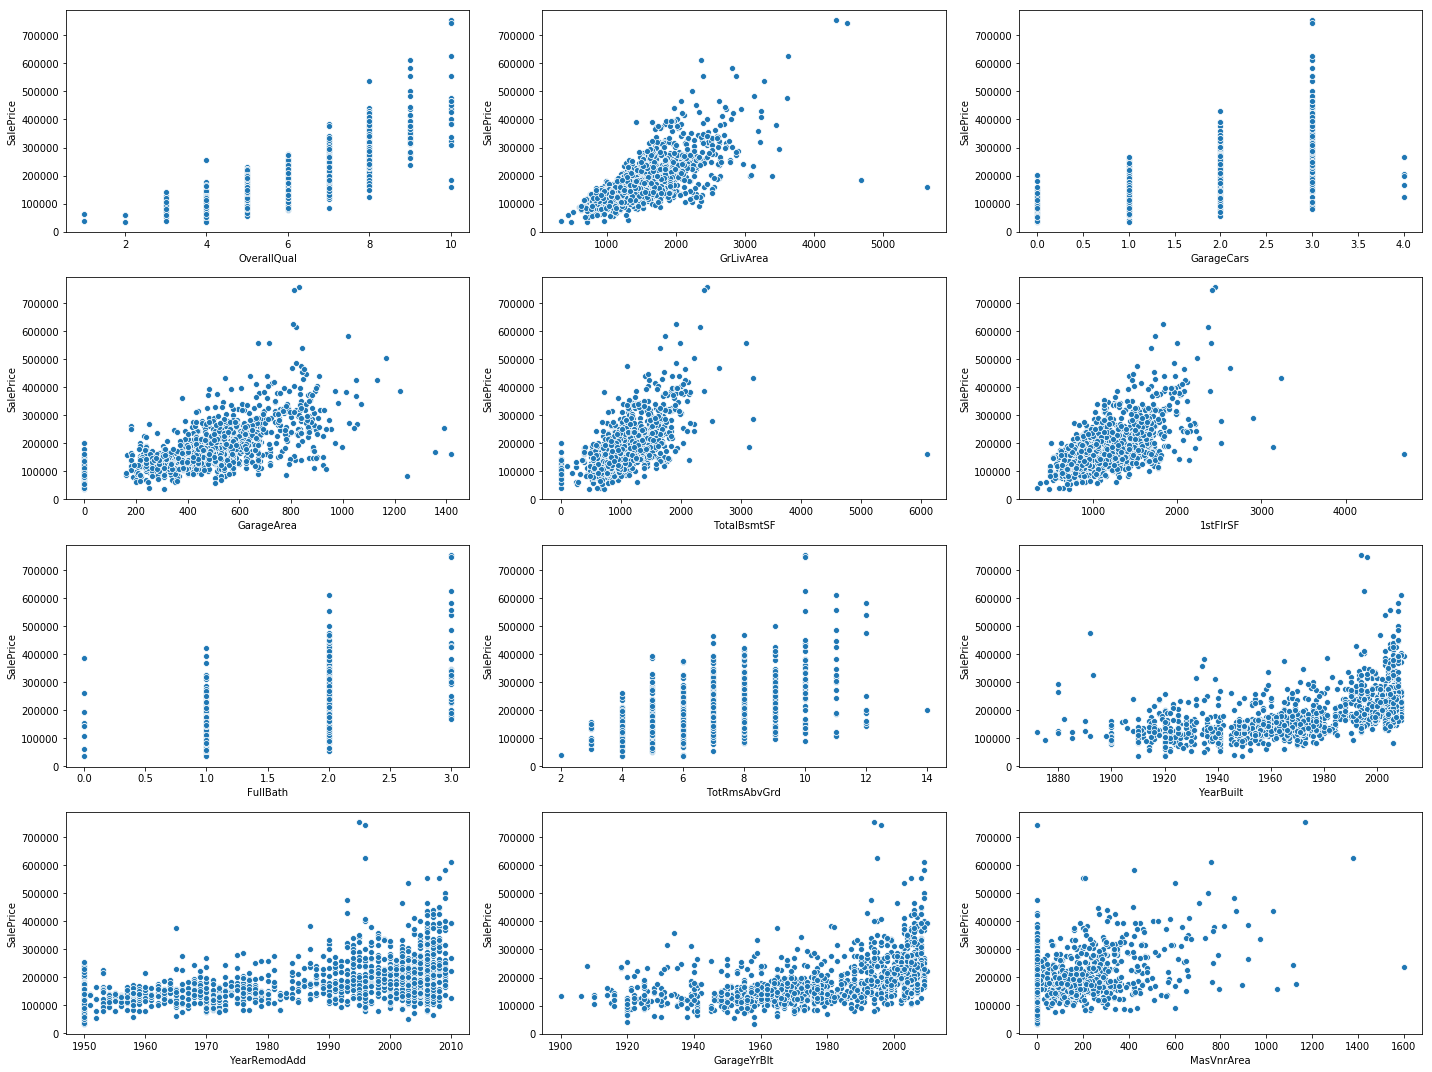

In [19]:
#scatterplot

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

for ax, index in zip(axes.flatten(), details.index):
    sns.scatterplot(ax=ax, x = train[index], y = train.SalePrice)

plt.tight_layout(); 

In [20]:
#remove outliers

train = train.loc[train.GrLivArea <= 4500]
train = train.loc[train.TotalBsmtSF < 6000]
train = train.loc[train['1stFlrSF'] < 4000]

In [21]:
get_details(train[cont]).loc[['GarageYrBlt', 'LotFrontage']]

,skew,corr,nulls,nulls_perc,unique
GarageYrBlt,-0.648137,0.487156,81,5.555556,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."
LotFrontage,1.543043,0.370584,259,17.764060,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."


In [22]:
#merge train and test

data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [23]:
get_details(data).sort_values('nulls', ascending = False).head(10)

,skew,corr,nulls,nulls_perc,unique
PoolQC,NaN,NaN,2908,99.691464,"[[nan, Ex, Fa, Gd]]"
MiscFeature,NaN,NaN,2812,96.400411,"[[nan, Shed, Gar2, Othr, TenC]]"
Alley,NaN,NaN,2719,93.212204,"[[nan, Grvl, Pave]]"
Fence,NaN,NaN,2346,80.425094,"[[nan, MnPrv, GdWo, GdPrv, MnWw]]"
SalePrice,1.881296,1.000000,1459,50.017141,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500..."
FireplaceQu,NaN,NaN,1420,48.680151,"[[nan, TA, Gd, Fa, Ex, Po]]"
LotFrontage,1.122014,0.370584,486,16.660953,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."
GarageCond,NaN,NaN,159,5.450806,"[[TA, Fa, nan, Gd, Po, Ex]]"
GarageFinish,NaN,NaN,159,5.450806,"[[RFn, Unf, Fin, nan]]"
GarageYrBlt,-0.381162,0.487156,159,5.450806,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."


In [24]:
#impute NaN

data['PoolQC'].loc[data.PoolQC.isnull() & data.PoolArea == 0] = 'NA'
data['MiscFeature'].loc[data.MiscFeature.isnull() & (data.MiscVal == 0)] = 'NA'
data['Alley'].loc[data.Alley.isnull()] = 'NA'
data['Fence'].loc[data.Fence.isnull()] = 'NA'
data['FireplaceQu'].loc[data.FireplaceQu.isnull()] = 'NA'
data['LotFrontage'].loc[data.LotFrontage.isnull()] = 0

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
# data = data.drop(['Utilities', 'PoolQC'], axis = 1)

In [26]:
fill = pd.Series([data[c].value_counts().index[0] for c in data[cat]],
            index=data[cat].columns)

data[cat] = data[cat].fillna(fill)

In [27]:
details = get_details(data)
details.loc[details.nulls > 0].sort_values('nulls', ascending = False)

,skew,corr,nulls,nulls_perc,unique
SalePrice,1.881296,1.000000,1459,50.017141,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500..."
GarageYrBlt,-0.381162,0.487156,159,5.450806,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."
MasVnrArea,2.610712,0.482719,23,0.788481,"[[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286...."
BsmtFullBath,0.621642,0.228459,2,0.068564,"[[1.0, 0.0, 2.0, 3.0, nan]]"
BsmtHalfBath,3.930420,-0.016881,2,0.068564,"[[0.0, 1.0, 2.0, nan]]"
BsmtFinSF1,0.980788,0.409384,1,0.034282,"[[706.0, 978.0, 486.0, 216.0, 655.0, 732.0, 13..."
BsmtFinSF2,4.145816,-0.011422,1,0.034282,"[[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0,..."
BsmtUnfSF,0.920173,0.214460,1,0.034282,"[[150.0, 284.0, 434.0, 540.0, 490.0, 64.0, 317..."
TotalBsmtSF,0.676548,0.651153,1,0.034282,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
GarageCars,-0.218089,0.641047,1,0.034282,"[[2.0, 3.0, 1.0, 0.0, 4.0, 5.0, nan]]"


In [28]:
fill = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.mean()))

In [29]:
fill = ['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageYrBlt']

for i in fill:
    data.loc[data[i].isnull(), i] = data.groupby(['OverallQual', 'Neighborhood'])[i].transform(lambda x: x.fillna(x.median()))

In [30]:
data.loc[data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = data.GarageYrBlt.median()

In [31]:
#encode categorical

le = LabelEncoder()

for i in cat:
    data[i] = le.fit_transform(data[i])

In [32]:
data_copy = data

In [33]:
data = data_copy

In [34]:
data.loc[data['SalePrice'].isnull(), 'SalePrice'] = 0

details = get_details(data[cont]).sort_values('skew', ascending = False)
details

,skew,corr,nulls,nulls_perc,unique
MiscVal,21.950962,-0.017858,0,0.0,"[[0.0, 700.0, 350.0, 500.0, 400.0, 480.0, 450...."
PoolArea,17.697766,0.049490,0,0.0,"[[0.0, 512.0, 648.0, 576.0, 555.0, 519.0, 738...."
LotArea,13.116240,0.161167,0,0.0,"[[8450.0, 9600.0, 11250.0, 9550.0, 14260.0, 14..."
LowQualFinSF,12.090757,0.011117,0,0.0,"[[0.0, 360.0, 513.0, 234.0, 528.0, 572.0, 144...."
3SsnPorch,11.377932,0.046664,0,0.0,"[[0.0, 320.0, 407.0, 130.0, 180.0, 168.0, 140...."
KitchenAbvGr,4.302763,-0.043897,0,0.0,"[[1.0, 2.0, 3.0, 0.0]]"
BsmtFinSF2,4.146636,-0.019050,0,0.0,"[[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0,..."
EnclosedPorch,4.004404,-0.060589,0,0.0,"[[0.0, 272.0, 228.0, 205.0, 176.0, 87.0, 172.0..."
ScreenPorch,3.947131,0.026259,0,0.0,"[[0.0, 176.0, 198.0, 291.0, 252.0, 99.0, 184.0..."
BsmtHalfBath,3.932018,-0.019090,0,0.0,"[[0.0, 1.0, 2.0]]"


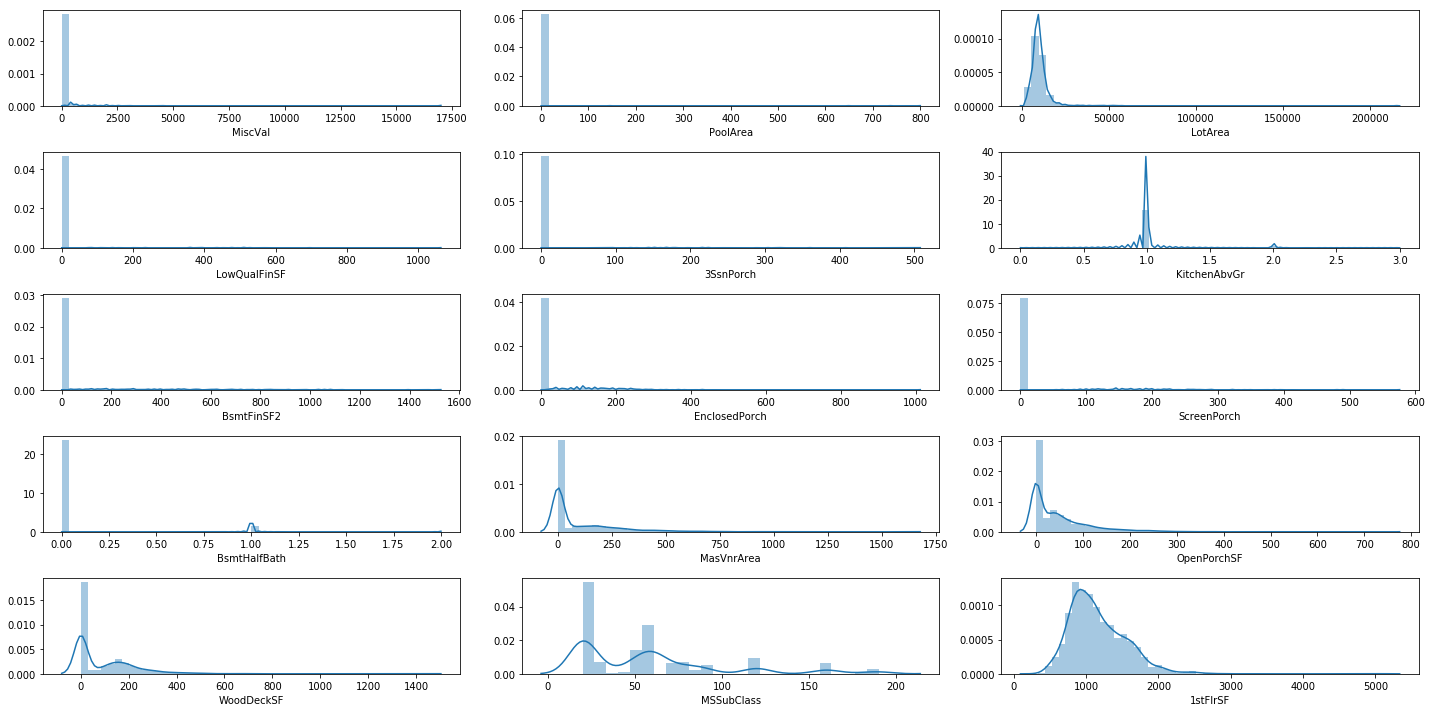

In [35]:
# graph distribution

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for ax, index in zip(axes.flatten(), details.head(15).index):
    sns.distplot(ax=ax, a =data[index]);

plt.tight_layout(); 

In [36]:
cols = details.loc[abs(details['skew'] > 0.7)].index.to_list()
cols.remove('SalePrice')

In [37]:
# Boxcox
x = data[cols]

for i in cols:
    posdata = data.loc[data[i] > 0, i]
    bcdata, lam = boxcox(posdata)

    x.loc[data[i] > 0, i] = bcdata
    x.loc[data[i] == 0, i] = -1/lam

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/sofiawangy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

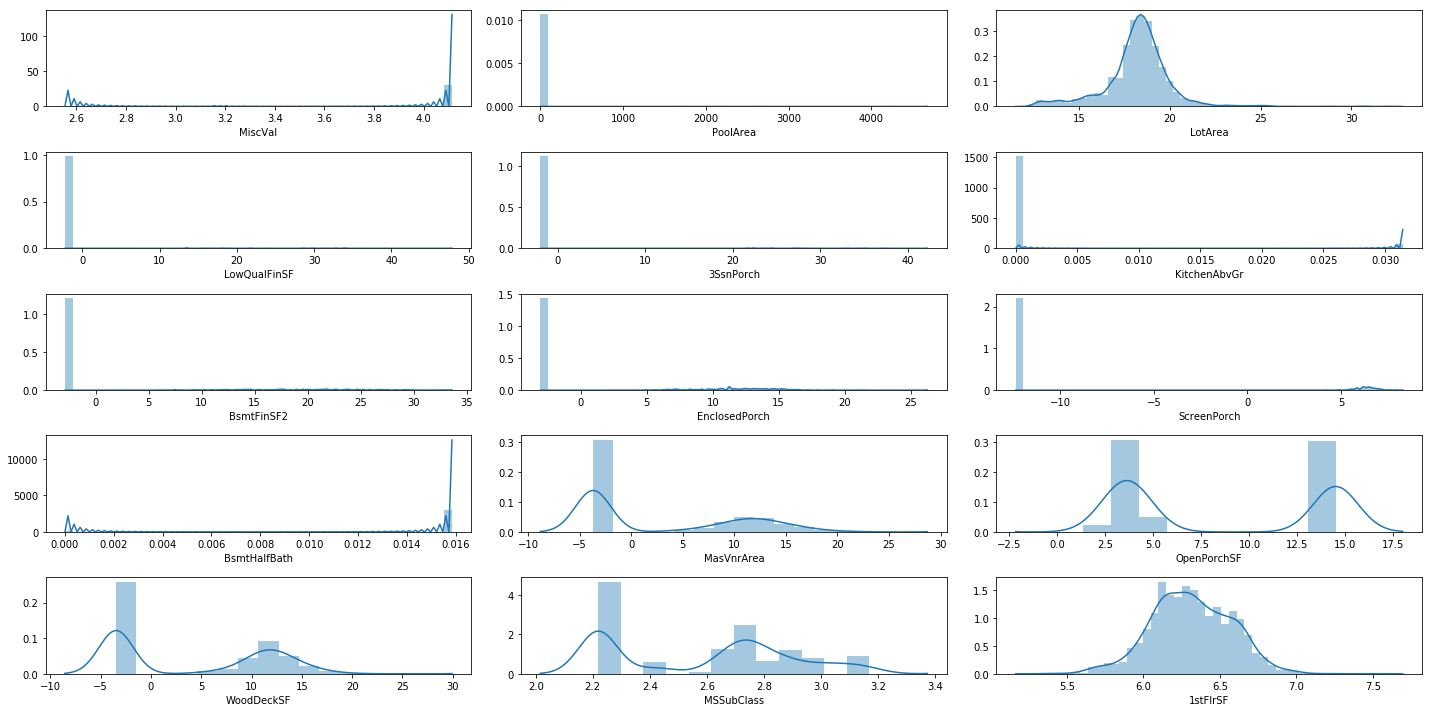

In [38]:
# graph new distribution

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

for ax, index in zip(axes.flatten(), details.head(15).index):
    sns.distplot(ax=ax, a =x[index]);

plt.tight_layout(); 

In [39]:
# data[cols] = x[cols]

get_details(data).sort_values('skew', ascending = False).head()

,skew,corr,nulls,nulls_perc,unique
Utilities,54.009258,0.008184,0,0.0,"[[0.0, 1.0]]"
MiscVal,21.950962,-0.017858,0,0.0,"[[0.0, 700.0, 350.0, 500.0, 400.0, 480.0, 450...."
PoolArea,17.697766,0.049490,0,0.0,"[[0.0, 512.0, 648.0, 576.0, 555.0, 519.0, 738...."
LotArea,13.116240,0.161167,0,0.0,"[[8450.0, 9600.0, 11250.0, 9550.0, 14260.0, 14..."
Condition2,12.347339,0.026003,0,0.0,"[[2.0, 0.0, 7.0, 1.0, 3.0, 4.0, 6.0, 5.0]]"


In [40]:
#go back to train and test
train  = data.loc[data.SalePrice > 0,]
test = data.loc[data.SalePrice == 0,]

In [41]:
train.SalePrice, lmbda = boxcox(train.SalePrice)

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


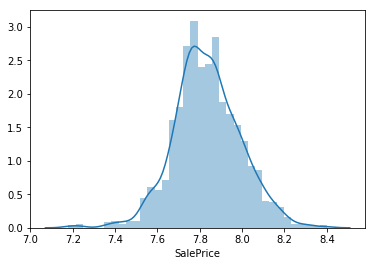

In [42]:
sns.distplot(train.SalePrice)

In [43]:
get_details(train).sort_values('corr', ascending = False)

,skew,corr,nulls,nulls_perc,unique
SalePrice,-0.008634,1.000000,0,0.0,"[[7.9241748085326575, 7.869963589172873, 7.951..."
OverallQual,0.200786,0.819189,0,0.0,"[[7.0, 6.0, 8.0, 5.0, 9.0, 4.0, 10.0, 3.0, 1.0..."
GrLivArea,1.010992,0.721006,0,0.0,"[[1710.0, 1262.0, 1786.0, 1717.0, 2198.0, 1362..."
GarageCars,-0.342377,0.680590,0,0.0,"[[2.0, 3.0, 1.0, 0.0, 4.0]]"
GarageArea,0.131748,0.654800,0,0.0,"[[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 63..."
TotalBsmtSF,0.511703,0.644220,0,0.0,"[[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ..."
1stFlrSF,0.887637,0.616753,0,0.0,"[[856.0, 1262.0, 920.0, 961.0, 1145.0, 796.0, ..."
FullBath,0.031271,0.595113,0,0.0,"[[2.0, 1.0, 3.0, 0.0]]"
YearBuilt,-0.612295,0.588491,0,0.0,"[[2003.0, 1976.0, 2001.0, 1915.0, 2000.0, 1993..."
YearRemodAdd,-0.501838,0.567250,0,0.0,"[[2003.0, 1976.0, 2002.0, 1970.0, 2000.0, 1995..."


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size=0.2)

In [230]:
#pvalues

x = sm.add_constant(X_train)
results = sm.OLS(list(Y_train), x).fit()
pValues = results.pvalues
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     164.1
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:06:57   Log-Likelihood:                 1963.0
No. Observations:                1166   AIC:                            -3772.
Df Residuals:                    1089   BIC:                            -3382.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.6501      2.188      4.867

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [231]:
pValues = list(pValues[pValues<0.05].index)
X_train = X_train.loc[:, pValues[1:]]
X_test = X_test.loc[:, pValues[1:]]

In [81]:
r2 = pd.DataFrame(columns= ['r2_train', 'r2_test', 'MSE'])

In [232]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

y_pred = lm.predict(X_test)

r2.loc['Linear', 'r2_train'] = lm.score(X_train, Y_train)
r2.loc['Linear', 'r2_test'] = lm.score(X_test, Y_test)
r2.loc['Linear', 'MSE'] = mse(Y_test, y_pred)

Text(0.5, 1.0, 'train')

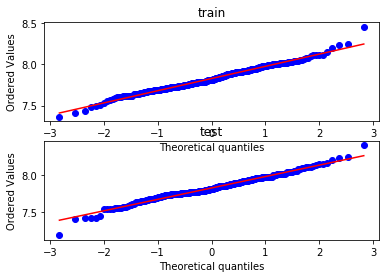

In [234]:
from scipy import stats
fig = plt.figure()
ax2 = fig.add_subplot(212)
prob = stats.probplot(Y_test, dist=stats.norm, plot=ax2)
plt.title('test')

ax1 = fig.add_subplot(211)
prob = stats.probplot(y_pred, dist=stats.norm, plot=ax1)
plt.title('train')

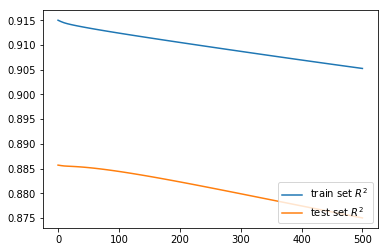

In [235]:
ridge = Ridge()

train_R2 = []
test_R2  = []
alphaRange = np.linspace(1e-4,500,100)
for alpha in alphaRange:
    ridge.set_params(alpha=alpha, normalize=False)  
    ridge.fit(X_train, Y_train)
    train_R2.append(ridge.score(X_train, Y_train))
    test_R2.append(ridge.score(X_test, Y_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

In [236]:
ridge.set_params(alpha=1e-4)
ridge.fit(X_train, Y_train)

y_pred = ridge.predict(X_test)

r2.loc['Ridge', 'r2_train'] = ridge.score(X_train, Y_train)
r2.loc['Ridge', 'r2_test'] = ridge.score(X_test, Y_test)
r2.loc['Ridge', 'MSE'] = mse(Y_test, y_pred)

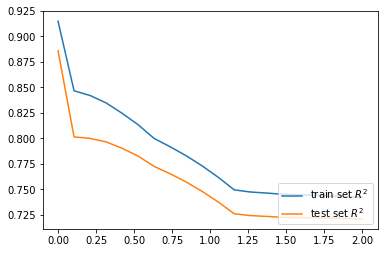

In [237]:
lasso = Lasso()

train_R2 = []
test_R2  = []
alphaRange = np.linspace(1e-4,2,20)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, max_iter=2000)  
    lasso.fit(X_train, Y_train)
    train_R2.append(lasso.score(X_train, Y_train))
    test_R2.append(lasso.score(X_test, Y_test))
    
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)   

In [238]:
lasso.set_params(alpha=1e-4)
lasso.fit(X_train, Y_train)

y_pred = lasso.predict(X_test)

r2.loc['Lasso', 'r2_train'] = lasso.score(X_train, Y_train)
r2.loc['Lasso', 'r2_test'] = lasso.score(X_test, Y_test)
r2.loc['Lasso', 'MSE'] = mse(Y_test, y_pred)

In [279]:
net = ElasticNet()

alphaSize  = 100
rhoSize    = 100
alphaRange = np.linspace(1, 10, alphaSize)
rhoRange   = np.linspace(1, 10, rhoSize)
trainR2    = np.zeros((alphaSize, rhoSize))
testR2     = np.zeros((alphaSize, rhoSize))
net.set_params(normalize=False)

for alphaIdx, alpha in enumerate(alphaRange):
    for rhoIdx, rho in enumerate(rhoRange):
        net.set_params(alpha=alpha, l1_ratio=rho)
        net.fit(X_train, Y_train)
        trainR2[alphaIdx, rhoIdx] = net.score(X_train, Y_train)
        testR2[alphaIdx, rhoIdx]  = net.score(X_test, Y_test)

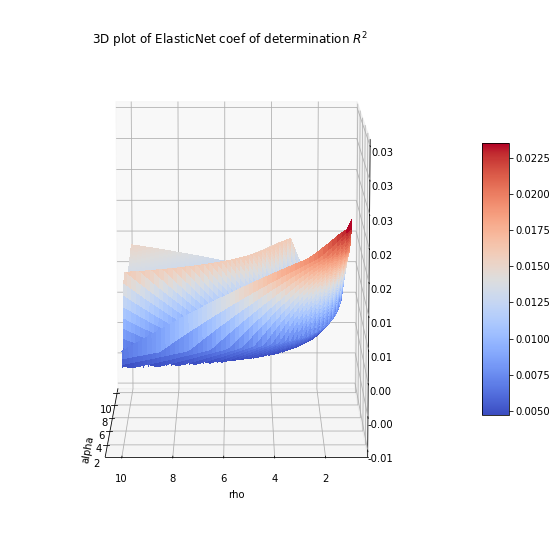

In [264]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# Make data
x = alphaRange
y = rhoRange
X, Y = np.meshgrid(x, y)
Z = (trainR2-testR2).T
# Z = (testR2).T
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(np.min(Z) - 0.01, np.max(Z) + 0.01)
ax.view_init(10, 180)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel('alpha')
plt.ylabel('rho')
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

In [304]:
net.set_params(alpha=0.05, l1_ratio=0.05)
net.fit(X_train, Y_train)

y_pred = net.predict(X_test)

print(net.score(X_train, Y_train))
print(net.score(X_test, Y_test))

r2.loc['ElasticNet', 'r2_train'] = net.score(X_train, Y_train)
r2.loc['ElasticNet', 'r2_test'] = net.score(X_test, Y_test)
r2.loc['ElasticNet', 'MSE'] = mse(Y_test, y_pred)

0.9050597457106933
0.8812508625766559


In [374]:
data = data_copy

train  = data.loc[data.SalePrice > 0,]
test = data.loc[data.SalePrice == 0,]

rfX_train, rfX_test, rfY_train, rfY_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size=0.2)

Y_train_le = le.fit_transform(rfY_train)
Y_test_le = le.fit_transform(rfY_test)

randomForest = ensemble.RandomForestClassifier()
# randomForest.set_params(random_state=42, n_estimators=100, max_features=2)
# randomForest.fit(rfX_train, Y_train_le)

# feature_importance = list(zip(rfX_train.columns, randomForest.feature_importances_))
# dtype = [('feature', 'S10'), ('importance', 'float')]
# feature_importance = np.array(feature_importance, dtype=dtype)
# feature_sort = np.sort(feature_importance, order='importance')[::-1]
# name, score = zip(*list(feature_sort))
# pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')


In [376]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
randomForest.set_params(random_state=42)
grid_search_tree = GridSearchCV(randomForest, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
%time grid_search_tree.fit(rfX_train, rfY_train)

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 12.2 s, sys: 6.25 s, total: 18.5 s
Wall time: 3min 24s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [377]:
print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)
print(grid_search_tree.score(rfX_train, rfY_train))
print(grid_search_tree.score(rfX_test, rfY_test))

{'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 18}
0.024871355060034305
0.7161234991423671
0.0


/home/sofiawangy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


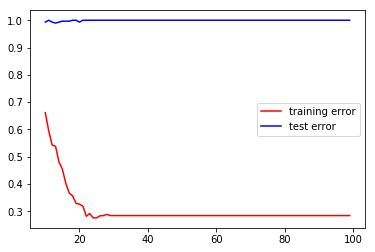

In [378]:
# cols = ['LotArea', 'BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea','GarageYrBlt', 'MoSold',
#         'YearRemodAdd', 'YearBuilt', 'LotFrontage','BsmtFinSF1', 'OpenPorchSF', 'YrSold', 'Neighborhood']

# rfX_train = rfX_train[cols]
# rfX_test = rfX_test[cols]

depth = range(10, 100)
train_error2 = []
test_error2 = []

for i in depth:
    randomForest.set_params(max_depth=i, min_samples_leaf=4, min_samples_split= 18)
    randomForest.fit(rfX_train, rfY_train)
    train_error2.append(1- randomForest.score(rfX_train, rfY_train))
    test_error2.append(1- randomForest.score(rfX_test, rfY_test))

import matplotlib.pyplot as plt
plt.plot(depth, train_error2, c='red', label='training error')
plt.plot(depth, test_error2, c='blue', label='test error')
plt.legend()
plt.show()

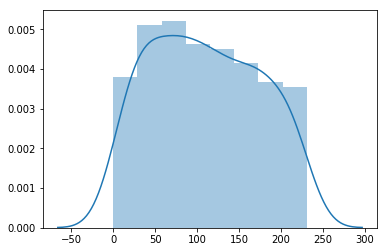

In [367]:
sns.distplot(Y_test_le)

In [352]:
train_error2

[0.4554030874785592,
 0.6295025728987993,
 0.79073756432247,
 0.8902229845626072,
 0.9442538593481989,
 0.9862778730703259,
 0.9931389365351629,
 0.9982847341337907,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954,
 0.9991423670668954]

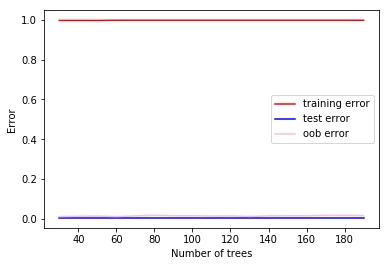

In [347]:


n_trees_range = range(30, 200, 10)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []
oob_error = []

for n_trees in n_trees_range:
    randomForest.set_params(n_estimators=n_trees, random_state=42, oob_score=True)
    randomForest.fit(rfX_train, Y_train_le)
    train_error2.append(randomForest.score(rfX_train, Y_train_le))
    test_error2.append(randomForest.score(rfX_test, Y_test_le))
    oob_error.append(randomForest.oob_score_)
    
plt.plot(n_trees_range, train_error2, c='red', label='training error')
plt.plot(n_trees_range, test_error2, c='blue', label='test error')
plt.plot(n_trees_range, oob_error, c='pink', label='oob error')
plt.ylabel('Error')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

In [350]:
from xgboost import XGBClassifier

xgX_train, xgX_test, xgY_train, xgY_test = train_test_split(train.iloc[:,:-1], train.iloc[:,-1], test_size=0.2)

xgboost = XGBClassifier()
randomForest.set_params(random_state=42, n_estimators=100)
randomForest.fit(xgX_train, xgY_test)

# feature_importance = list(zip(rfX_train.columns, randomForest.feature_importances_))
# dtype = [('feature', 'S10'), ('importance', 'float')]
# feature_importance = np.array(feature_importance, dtype=dtype)
# feature_sort = np.sort(feature_importance, order='importance')[::-1]
# name, score = zip(*list(feature_sort))
# pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

ModuleNotFoundError: No module named 'xgboost'

In [310]:
r2

,r2_train,r2_test,MSE
Linear,0.915042,0.885687,0.00274211
Ridge,0.915042,0.885687,0.00274211
Lasso,0.914918,0.885862,0.00273792
ElasticNet,0.90506,0.881251,0.00284853
